In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


In [5]:
# Define dataset paths and their corresponding passenger counts
dataset_info = {
    "luggage_dataset1_128.csv": 128,
    "luggage_dataset2_128.csv": 128,
    "luggage_dataset1_250.csv": 250,
    "luggage_dataset2_250.csv": 250,
    "luggage_dataset1_300.csv": 300,
    "luggage_dataset2_300.csv": 300,
    "luggage_dataset1_350.csv": 350,
    "luggage_dataset2_350.csv": 350
}

# Load and combine all datasets with a new column
dfs = []
for file_name, passenger_count in dataset_info.items():
    df_temp = pd.read_csv(f"/Users/layal/Desktop/{file_name}")
    df_temp["Passenger_Count"] = passenger_count
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

df = df[df['Cluster_Size'] != 1]

# Keep only rows with required time columns
df = df.dropna(subset=[
     'Flight_Arrival_Time', 'Estimated_Arrival_Time', 'Actual_Arrival_Time', 'Cluster_Size'
])

df["Flight_Arrival_Time"] = pd.to_datetime(df["Flight_Arrival_Time"])
df["Estimated_Arrival_Time"] = pd.to_datetime(df["Estimated_Arrival_Time"])
df["Actual_Arrival_Time"] = pd.to_datetime(df["Actual_Arrival_Time"])


# Now compute the error in seconds
df["Error_Seconds"] = (df["Actual_Arrival_Time"] - df["Estimated_Arrival_Time"]).dt.total_seconds()
df["Error_Minutes"] = df["Error_Seconds"] / 60

# Define features and target
y = df["Error_Seconds"].values
X = df[['Flight_Arrival_Time', 'Estimated_Arrival_Time', 'Actual_Arrival_Time', 'Cluster_Size', 'Passenger_Count']].copy()


def encode_circular_hour(series):
    radians = (series / 24) * 2 * np.pi
    return np.sin(radians), np.cos(radians)

# Extract hour from each datetime and encode circularly
for col in ['Flight_Arrival_Time', 'Estimated_Arrival_Time', 'Actual_Arrival_Time']:
    hour_col = col + '_Hour'
    X[hour_col] = X[col].dt.hour
    X[hour_col + '_sin'], X[hour_col + '_cos'] = encode_circular_hour(X[hour_col])

# Drop original datetime and hour columns (only keep sine and cosine encodings)
X = X.drop(columns=['Flight_Arrival_Time', 'Estimated_Arrival_Time', 'Actual_Arrival_Time'])


/var/folders/1q/vly_xpw52ss__8lr1wl63j2h0000gn/T/ipykernel_17222/4068909177.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Flight_Arrival_Time"] = pd.to_datetime(df["Flight_Arrival_Time"])
/var/folders/1q/vly_xpw52ss__8lr1wl63j2h0000gn/T/ipykernel_17222/4068909177.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Estimated_Arrival_Time"] = pd.to_datetime(df["Estimated_Arrival_Time"])
/var/folders/1q/vly_xpw52ss__8lr1wl63j2h0000gn/T/ipykernel_17222/4068909177.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Actual_Arrival_Time"] = pd.to_datetime(df["

In [6]:
# Scale input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=500, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf', C=75, epsilon=0.1, gamma='auto'),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10)
}

scoring = {
    'r2': 'r2',
    'neg_mae': 'neg_mean_absolute_error',
    'neg_mse': 'neg_mean_squared_error'
}
# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_results = {}

for name, model in tqdm(models.items(), desc="Training Models", unit="model"):
    scores = cross_validate(model, X_trainval, y_trainval, cv=kf, scoring=scoring)

    r2 = np.mean(scores['test_r2'])
    mae = -np.mean(scores['test_neg_mae'])
    mse = -np.mean(scores['test_neg_mse'])
    
    model_results[name] = {'R2': r2, 'MAE': mae, 'MSE': mse}
    print(f"{name}: CV R² = {r2:.4f}, MAE = {mae:.4f}, MSE = {mse:.4f}")


Training Models:  25%|██▌       | 1/4 [00:14<00:44, 14.93s/model]

Gradient Boosting: CV R² = 0.7969, MAE = 320.9502, MSE = 168120.0343


Training Models:  50%|█████     | 2/4 [00:27<00:26, 13.35s/model]

Random Forest: CV R² = 0.7968, MAE = 321.0690, MSE = 168246.1116


Training Models: 100%|██████████| 4/4 [00:57<00:00, 14.43s/model]

Support Vector Regressor: CV R² = 0.6505, MAE = 410.9917, MSE = 289388.4978
K-Nearest Neighbors: CV R² = 0.7749, MAE = 334.6548, MSE = 186317.7956


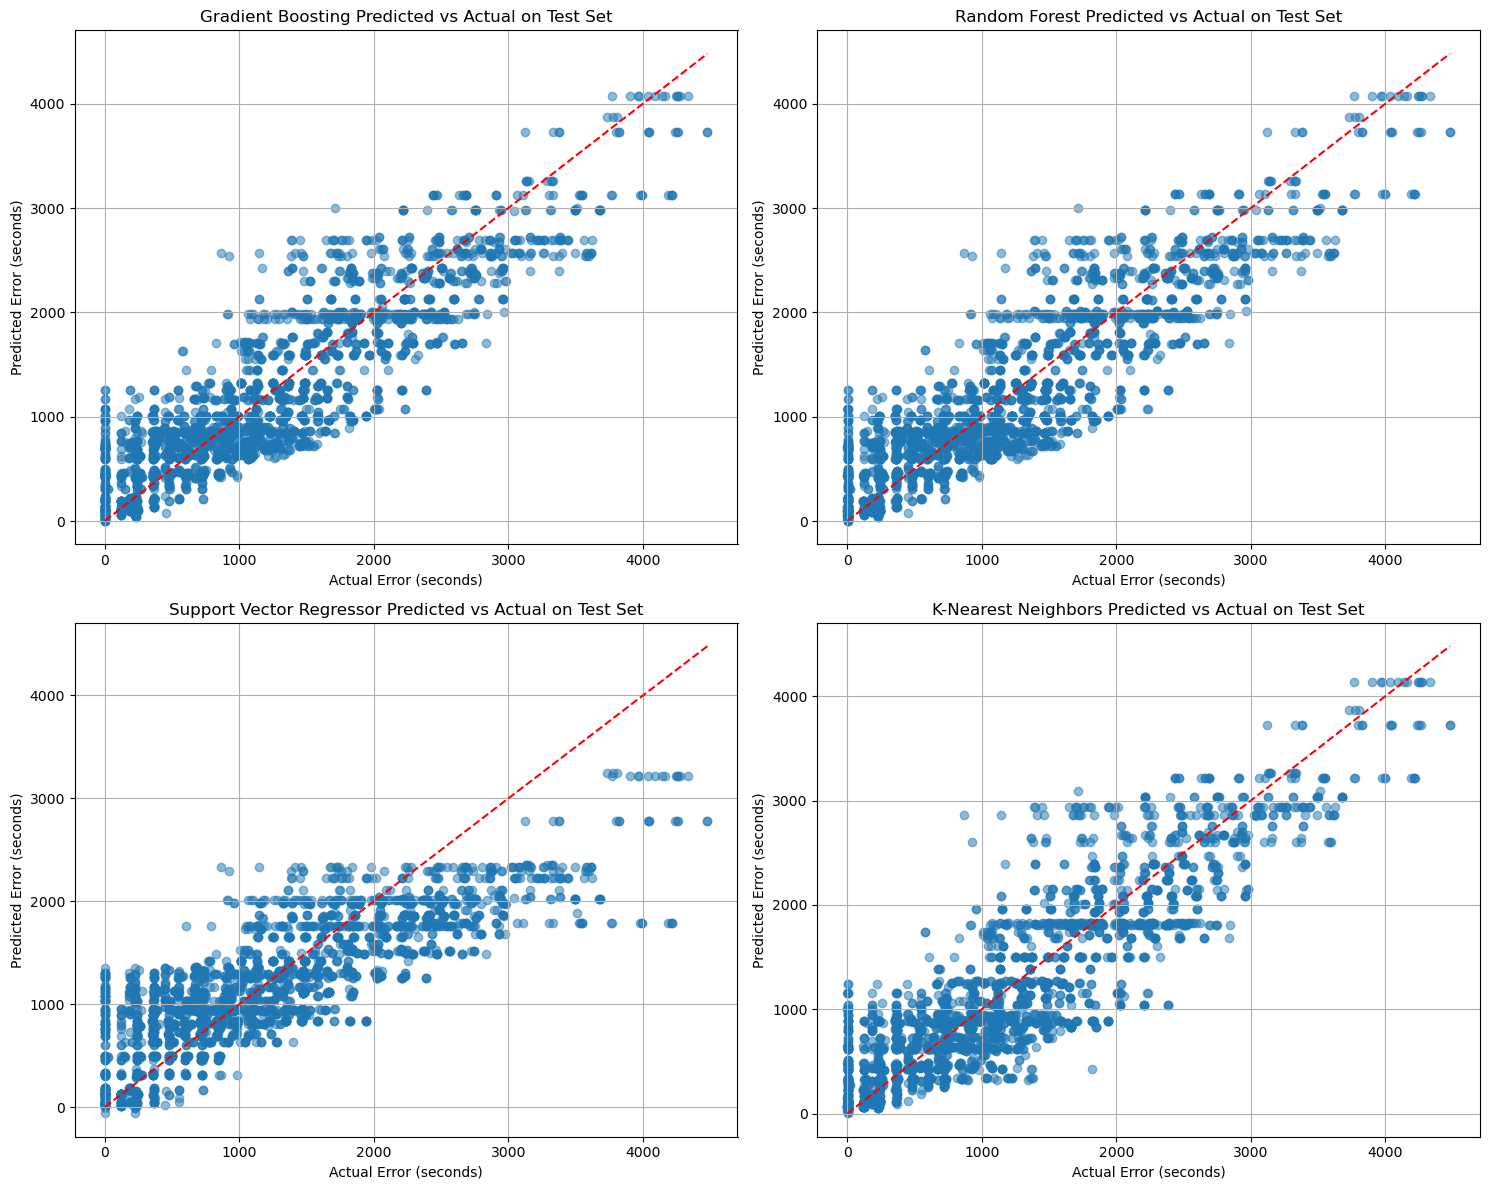

In [10]:
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_trainval, y_trainval)            # Train on full 80%
    y_pred = model.predict(X_test)               # Predict on 20% test set

    plt.subplot(2, 2, i)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{name} Predicted vs Actual on Test Set')
    plt.xlabel('Actual Error (seconds)')
    plt.ylabel('Predicted Error (seconds)')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Train best model on trainval
best_model_name = max(model_results, key=lambda name: model_results[name]['R2'])
best_model = models[best_model_name]
best_model.fit(X_trainval, y_trainval)

# Predict on test set
y_pred = best_model.predict(X_test)

# Plot predicted vs actual error (in seconds)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Error (seconds)")
plt.ylabel("Predicted Error (seconds)")
plt.title(f"{best_model_name} – Actual vs Predicted Error")
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = y_test - y_pred

# Plot residual distribution
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.title(f"{best_model_name} – Residuals Distribution")
plt.xlabel("Prediction Error (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()
